In [1]:
import sxdes
import galsim
import numpy as np
import proplot as pplt

import ngmix
from ngmix.metacal import get_all_metacal

In [2]:
def _run_det(psf, rng):
    nse = 3
    dim = 101
    cen = (dim-1)/2
    im = psf.drawImage(nx=dim, ny=dim, scale=0.263).array * 2e5
    im += rng.normal(size=im.shape, scale=nse)

    dim = 53
    psf_cen = (dim-1)/2
    psf_im = psf.drawImage(nx=dim, ny=dim, scale=0.263).array
    
    psf_obs = ngmix.Observation(
        image=psf_im,
        weight=np.ones_like(psf_im),
        jacobian=ngmix.DiagonalJacobian(scale=0.263, row=psf_cen, col=psf_cen)
    )
    obs = ngmix.Observation(
        image=im,
        weight=np.ones_like(im)/nse**2,
        noise=rng.normal(size=im.shape, scale=nse),
        jacobian=ngmix.DiagonalJacobian(scale=0.263, row=cen, col=cen),
        psf=psf_obs,
    )
    mcal_res = get_all_metacal(
        obs, psf="fitgauss", types=["noshear"], 
        use_noise_image=True, rng=rng,
    )

    im = mcal_res["noshear"].image.copy()
    nse = 1/np.sqrt(mcal_res["noshear"].weight[0, 0])
    cat, _ = sxdes.run_sep(im, nse)

    return cat, im, nse
    

<a list of 1 Line2D objects>

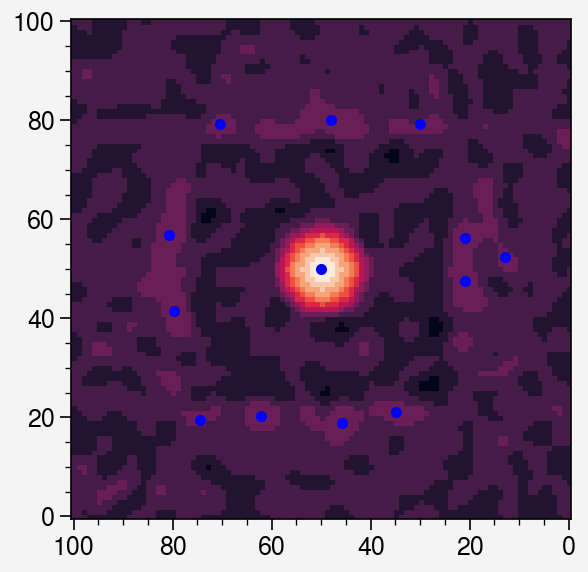

In [23]:
rng = np.random.RandomState()
psf = galsim.Moffat(beta=1.5, fwhm=1.2)
cat, im, nse = _run_det(psf, rng)

fig, axs = pplt.subplots()
axs.pcolormesh(np.arcsinh(im/nse), cmap="rocket")
axs.plot(cat["x"], cat["y"], '.b')

In [4]:
import joblib

import tqdm

psf = galsim.Moffat(beta=2.5, fwhm=1.2)

with joblib.Parallel(n_jobs=-1, verbose=10) as par:
    cats = par(
        joblib.delayed(_run_det)(psf, np.random.RandomState())
        for i in range(10000)
    )

cats = np.concatenate([
    c[0] for c in cats if len(c) > 1
])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 9629 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 9909 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  2.9min finished


(0.0, 100.0)

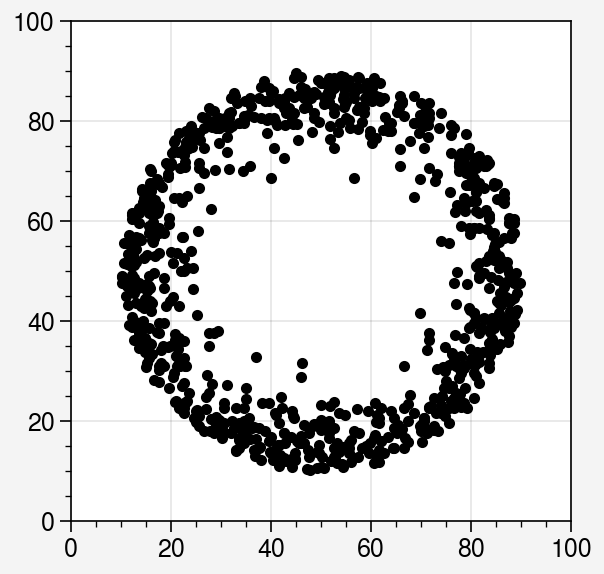

In [13]:
r = np.sqrt((np.abs(cats["x"]-50))**2 + (np.abs(cats["y"]-50))**2)
msk = (r > 5) & (r < 40)

fig, axs = pplt.subplots()
axs.plot(cats["x"][msk], cats["y"][msk], 'k.')
axs.set_xlim(0, 100)
axs.set_ylim(0, 100)

<a list of 1 Line2D objects>

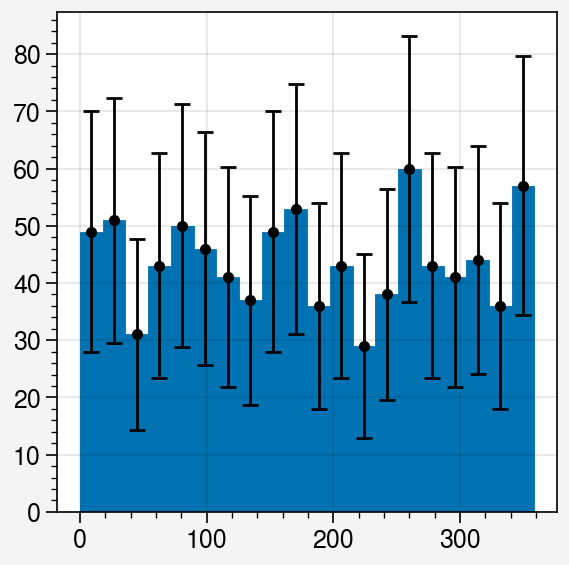

In [22]:
msk = (r > 5) & (r < 40)
a = np.arctan2(cats["y"][msk]-50, cats["x"][msk]-50)/np.pi*180 + 180

fig, axs = pplt.subplots()
h, be, _ = axs.hist(a, bins=20)
x = (be[1:] + be[:-1])/2
axs.plot(x, h, '.', bardata=np.sqrt(h)*3, color='k')


(21,)